<a href="https://colab.research.google.com/github/rllima/IF704/blob/main/Classification%20step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np

In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from google.colab import drive

In [166]:
##Metrics functions
#Metrics have been removed from Keras core. You need to calculate them manually. They removed them on 2.0 version. Those metrics are all global metrics, but Keras works in batches. As a result, it might be more misleading than helpful.
#However, if you really need them, you can do it like this

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [20]:
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [21]:
#Download do dataset
import requests, zipfile, io
r = requests.get("http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/drive/My Drive/IF704")
z.close()

In [22]:
!ls "/content/drive/My Drive/IF704/"

testdata.manual.2009.06.14.csv	training.1600000.processed.noemoticon.csv


In [132]:
df = pd.read_csv("/content/drive/My Drive/IF704/training.1600000.processed.noemoticon.csv",
                 names = ["target","id","date","query","user","text"], header=None, encoding='latin-1')

In [133]:
df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [134]:
df.dtypes

target     int64
id         int64
date      object
query     object
user      object
text      object
dtype: object

In [135]:
df.target.unique()

array([0, 4])

In [136]:
df.target = df.target.replace(to_replace=4,value=1)

In [137]:
df.target.unique()

array([0, 1])

In [138]:
###Preparando o dataset para tensorflow

In [139]:
target = df.pop('target')

In [140]:
dataset = tf.data.Dataset.from_tensor_slices((df.text.values, target.values))

In [141]:
dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [142]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: b"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", Target: 0
Features: b"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", Target: 0
Features: b'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', Target: 0
Features: b'my whole body feels itchy and like its on fire ', Target: 0
Features: b"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", Target: 0


In [143]:
DATASET_SIZE = df.shape[0]

In [144]:
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.take(test_size)

In [118]:
from collections import Counter
results = Counter()
df['text'].str.lower().str.split().apply(results.update)
print(len(results))

1193584


collections.Counter

In [145]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [146]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [147]:
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [148]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [149]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'in', 'for', 'of', 'im', 'on', 'me', 'so', 'have', 'that'],
      dtype='<U27')

In [94]:
encoded_example = encoder("I like so much")[:3].numpy()
encoded_example

array([ 2, 37, 17])

In [150]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [151]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [152]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00517517]


In [153]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [154]:
### Trainnig Model

In [155]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
10000/10000 [==============================] - 212s 21ms/step - loss: 0.0498 - accuracy: 0.9922 - val_loss: 2.2761e-04 - val_accuracy: 1.0000
Epoch 2/5
10000/10000 [==============================] - 201s 20ms/step - loss: 0.0595 - accuracy: 0.9857 - val_loss: 4.3559e-04 - val_accuracy: 1.0000
Epoch 3/5
10000/10000 [==============================] - 203s 20ms/step - loss: 0.0531 - accuracy: 0.9886 - val_loss: 2.8785e-04 - val_accuracy: 1.0000
Epoch 4/5
10000/10000 [==============================] - 201s 20ms/step - loss: 0.0312 - accuracy: 0.9934 - val_loss: 1.5030e-04 - val_accuracy: 1.0000
Epoch 5/5
10000/10000 [==============================] - 201s 20ms/step - loss: 0.0250 - accuracy: 0.9940 - val_loss: 1.0217e-04 - val_accuracy: 1.0000


In [156]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2500/2500 [==============================] - 17s 7ms/step - loss: 9.7037e-05 - accuracy: 1.0000
Test Loss: 9.703748219180852e-05
Test Accuracy: 0.9999906420707703


In [157]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.062449314345940365)

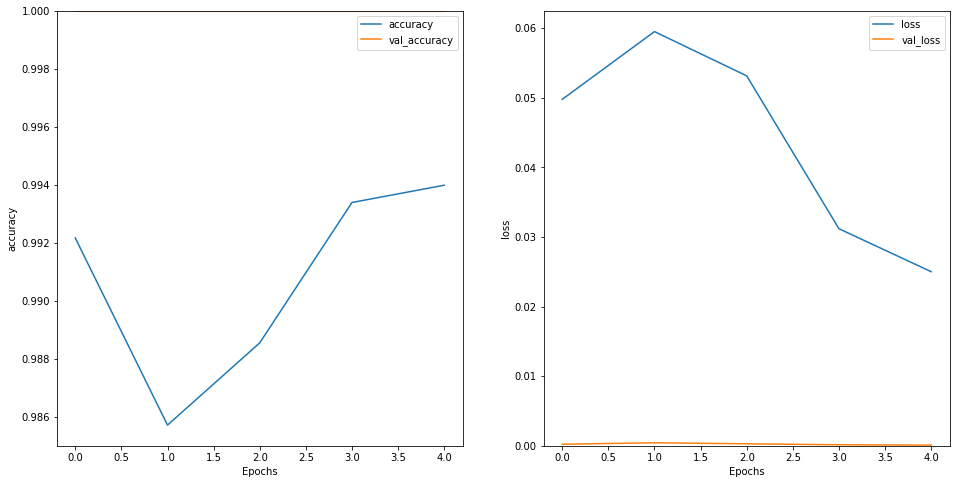

In [158]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [47]:
##Second configuration

In [160]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [161]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.00001),
              metrics=['accuracy'])

In [162]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
10000/10000 [==============================] - 333s 32ms/step - loss: 0.4798 - accuracy: 0.7355 - val_loss: 0.1463 - val_accuracy: 0.9888
Epoch 2/10
10000/10000 [==============================] - 318s 32ms/step - loss: 0.4692 - accuracy: 0.8003 - val_loss: 0.0488 - val_accuracy: 0.9893
Epoch 3/10
10000/10000 [==============================] - 318s 32ms/step - loss: 0.2317 - accuracy: 0.9216 - val_loss: 0.0207 - val_accuracy: 0.9987
Epoch 4/10
10000/10000 [==============================] - 320s 32ms/step - loss: 0.2790 - accuracy: 0.9021 - val_loss: 0.0141 - val_accuracy: 0.9990
Epoch 5/10
10000/10000 [==============================] - 323s 32ms/step - loss: 0.1489 - accuracy: 0.9585 - val_loss: 0.0088 - val_accuracy: 0.9992
Epoch 6/10
10000/10000 [==============================] - 323s 32ms/step - loss: 0.1026 - accuracy: 0.9745 - val_loss: 0.0056 - val_accuracy: 0.9995
Epoch 7/10
10000/10000 [==============================] - 323s 32ms/step - loss: 0.0819 - accuracy: 0.9803

In [163]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2500/2500 [==============================] - 25s 10ms/step - loss: 0.0018 - accuracy: 0.9996
Test Loss: 0.0018228248227387667
Test Accuracy: 0.9995531439781189


In [164]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[12.478511]]


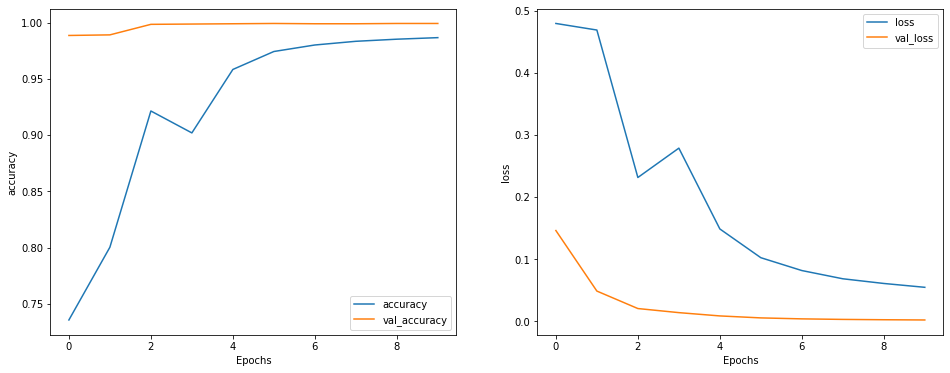

In [165]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')